In [2]:
import os
import random
data_folder = "./data/train"

os.listdir(data_folder)[5:10]

images = []
labels = []
categories = {"cat": 0, "dog": 1}

all_images = os.listdir(data_folder)
random.shuffle(all_images)

for file in all_images:
    if not file.endswith('.jpg'):
        continue
    image_path = os.path.join(data_folder, file)
    label = file.split(".")[0]
    images.append(image_path)
    labels.append(categories[label])
    
import cv2
import numpy as np

width = 64
height = 64

training_size = 100
test_size = 500
total_size = training_size + test_size


images = images[:total_size]
labels = labels[:total_size]

X = np.zeros([total_size, width, height, 3])

for i, image in enumerate(images):
    img = cv2.imread(image)
    resized_img = cv2.resize(img, (width, height))
    X[i] = resized_img
print(X.shape)

Y = np.zeros([total_size, 2])

for i, label in enumerate(labels):
    Y[i][label] = 1
    
X_train = X[:training_size]
Y_train = Y[:training_size]

X_test = X[training_size:]
Y_test = Y[training_size:]

(600, 64, 64, 3)


In [3]:
import tensorflow as tf


import tflearn
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.estimator import regression
from tflearn.data_preprocessing import ImagePreprocessing
from tflearn.data_augmentation import ImageAugmentation

def create_model():
    tf.reset_default_graph()

    img_prep = ImagePreprocessing()
    img_prep.add_featurewise_zero_center()
    img_prep.add_featurewise_stdnorm()

    # Create extra synthetic training data by flipping, rotating and blurring the
    # images on our data set.
    img_aug = ImageAugmentation()
    img_aug.add_random_flip_leftright()
    img_aug.add_random_rotation(max_angle=25.)
    img_aug.add_random_blur(sigma_max=3.)

    # Define our network architecture:

    # Input is a 64x64 x3(red, green and blue)
    network = input_data(shape=[None, width, height, 3],
                         data_preprocessing=img_prep,
                         data_augmentation=img_aug)

    # Step 1: Convolution
    conv_1 = conv_2d(network, 32, 3, activation='relu')

    # Step 2: Max pooling
    network = max_pool_2d(conv_1, 2)

    # Step 3: Convolution again
    network = conv_2d(network, 64, 3, activation='relu')

    # Step 4: Convolution yet again
    network = conv_2d(network, 64, 3, activation='relu')

    # Step 5: Max pooling again
    network = max_pool_2d(network, 2)

    # Step 6: Fully-connected 512 node neural network
    network = fully_connected(network, 512, activation='relu')

    # Step 7: Dropout - throw away some data randomly during training to prevent over-fitting
    network = dropout(network, 0.5)

    # Step 8: Fully-connected neural network with two outputs (0=isn't a bird, 1=is a bird) to make the final prediction
    network = fully_connected(network, 2, activation='softmax')

    # Tell tflearn how we want to train the network
    network = regression(network, optimizer='adam',
                         loss='categorical_crossentropy',
                         learning_rate=0.0005)

    # Wrap the network in a model object
    model = tflearn.DNN(network, 
                       tensorboard_verbose=1,
                       tensorboard_dir='tmp/')
    
    return conv_1, model

hdf5 is not supported on this machine (please install/reinstall h5py for optimal experience)


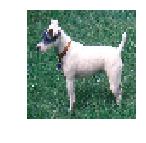

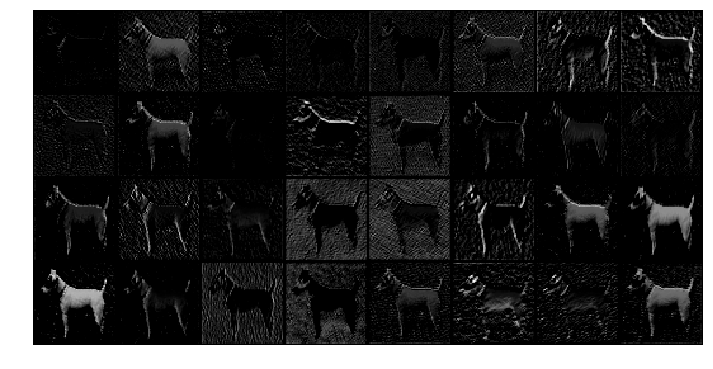

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

conv_1, model = create_model()
im = X_test[1:2]
plt.axis('off')
plt.imshow(im[0].astype('uint8'))
plt.gcf().set_size_inches(2, 2)

model.load("pretrained/catdog5k_128x128_100e.tfl")
# run images through 1st conv layer
m2 = tflearn.DNN(conv_1, session=model.session)



yhat = m2.predict(im)

# slice off outputs for first image and plot
yhat_1 = np.array(yhat[0])

def vis_conv(v,ix,iy,ch,cy,cx, p = 0) :
    v = np.reshape(v,(iy,ix,ch))
    ix += 2
    iy += 2
    npad = ((1,1), (1,1), (0,0))
    v = np.pad(v, pad_width=npad, mode='constant', constant_values=p)
    v = np.reshape(v,(iy,ix,cy,cx)) 
    v = np.transpose(v,(2,0,3,1)) #cy,iy,cx,ix
    v = np.reshape(v,(cy*iy,cx*ix))
    return v

#  h_conv1 - processed image
ix = 64  # img size
iy = 64
ch = 32   
cy = 4   # grid from channels:  32 = 4x8
cx = 8
v  = vis_conv(yhat_1,ix,iy,ch,cy,cx)
plt.figure(figsize = (12,12))
plt.imshow(v,cmap="Greys_r",interpolation='nearest')    
plt.axis('off');